# Requirements

In [6]:
import numpy as np
import pandas as pd

from datasets import Dataset, load_dataset

from transformers import DistilBertForSequenceClassification
from transformers import DistilBertTokenizer
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


import evaluate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [5]:
!pip install datasets transformers imbalanced-learn evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.3 MB/s eta 0:00:00


# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the current **mean temperature** in the city of Delhi. To accomplish this use data from the past three days, which includes information such as the **mean temperature**, **humidity**, **wind speed**, and **mean pressure**. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast the future mean temperature based on the provided historical data.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [8]:
data = pd.read_csv('data/climate-data.csv')
data

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


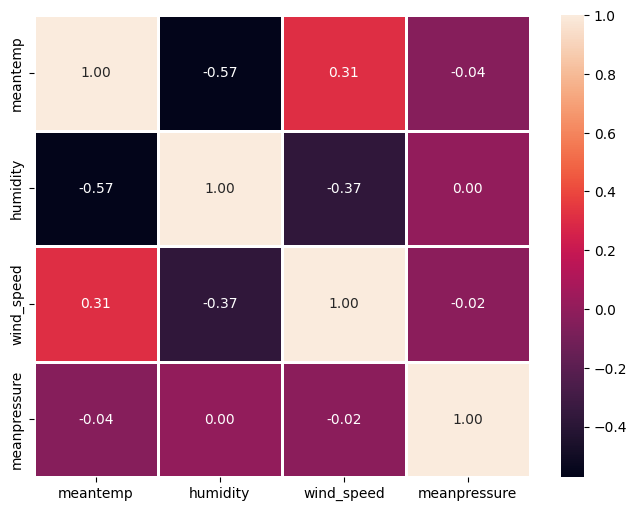

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, fmt='.2f', linewidths=2)
plt.show()

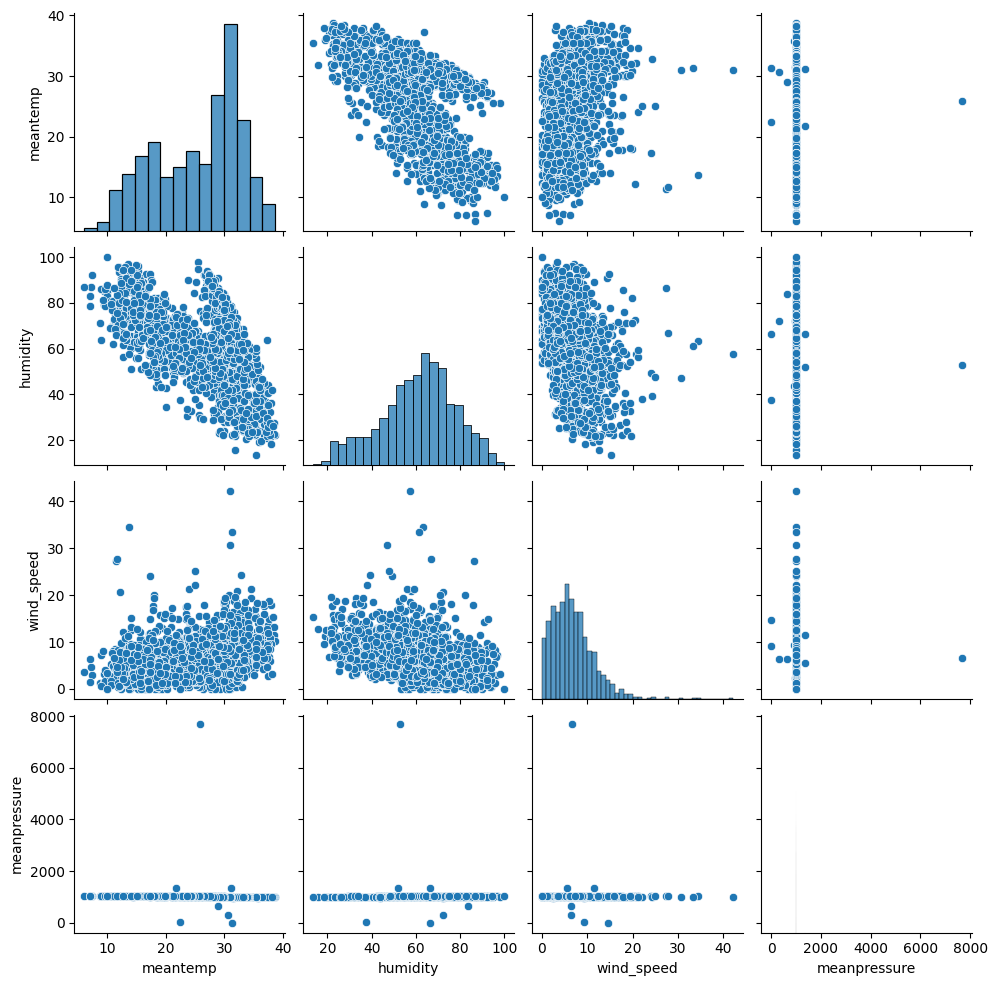

In [11]:
import seaborn as sns
sns.pairplot(data)

## Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

*Be careful when extracting the features. For each day, ensure that features are obtained sequentially, starting with those from 3 days ago, followed by features from 2 days ago, and finally, features from 1 day ago. This becomes crucial when reshaping the train and test sets later on.*

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [33]:
lags = range(3, 0, -1)
features = ['meantemp', 'humidity','wind_speed', 'meanpressure']

df = data.copy()

for lag in lags:
    for column in features:
        df[f'{column}_{lag}'] = df[column].shift(lag)

df.dropna(inplace=True)
df.head()


,meantemp,humidity,wind_speed,meanpressure,meantemp_3,humidity_3,wind_speed_3,meanpressure_3,meantemp_2,humidity_2,wind_speed_2,meanpressure_2,meantemp_1,humidity_1,wind_speed_1,meanpressure_1
date,,,,,,,,,,,,,,,,
2013-01-04,8.666667,71.333333,1.233333,1017.166667,10.000000,84.500000,0.000000,1015.666667,7.400000,92.000000,2.980000,1017.800000,7.166667,87.000000,4.633333,1018.666667
2013-01-05,6.000000,86.833333,3.700000,1016.500000,7.400000,92.000000,2.980000,1017.800000,7.166667,87.000000,4.633333,1018.666667,8.666667,71.333333,1.233333,1017.166667
2013-01-06,7.000000,82.800000,1.480000,1018.000000,7.166667,87.000000,4.633333,1018.666667,8.666667,71.333333,1.233333,1017.166667,6.000000,86.833333,3.700000,1016.500000
2013-01-07,7.000000,78.600000,6.300000,1020.000000,8.666667,71.333333,1.233333,1017.166667,6.000000,86.833333,3.700000,1016.500000,7.000000,82.800000,1.480000,1018.000000
2013-01-08,8.857143,63.714286,7.142857,1018.714286,6.000000,86.833333,3.700000,1016.500000,7.000000,82.800000,1.480000,1018.000000,7.000000,78.600000,6.300000,1020.000000


In [13]:
data['date'] = pd.to_datetime(data['date'])
data.set_index(keys='date', inplace=True)
data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [34]:
from sklearn.model_selection import train_test_split

X, y = df.drop(columns=features), df["meantemp"]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, shuffle=False)




## Feauture Scaling
Scale the extracted features using an appropriate scaler.

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

train_y = scaler.fit_transform(train_y.to_numpy().reshape(-1, 1))


## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [36]:
lags = 3
train_X = train_X.reshape(train_X.shape[0], lags, (train_X.shape[1] // lags))
test_X = test_X.reshape(test_X.shape[0], lags, (test_X.shape[1] // lags))


## Long Short-Term Memory (LSTM) Network
Build a Long Short-Term Memory (LSTM) Network for forecasting the current **mean temperature** based on the extracted features from the previous three days.

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [89]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

model = Sequential([
    Input((train_X.shape[1], train_X.shape[2],)),
    LSTM(4, activation="relu", return_sequences=True),
    LSTM(2, activation="relu"),
    Dense(1, activation="linear")
])


Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [90]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [91]:
history = model.fit(train_X, train_y, validation_split=0.2, epochs=3, batch_size=8, shuffle=False)


Epoch 1/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3132 - mean_squared_error: 0.3132 - val_loss: 0.2263 - val_mean_squared_error: 0.2263
Epoch 2/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1030 - mean_squared_error: 0.1030 - val_loss: 0.0249 - val_mean_squared_error: 0.0249
Epoch 3/3
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0161 - val_mean_squared_error: 0.0161


Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

<Axes: >

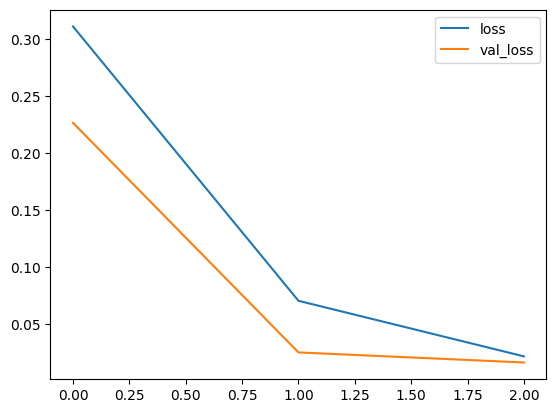

In [92]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")


Use the trained model to make predictions for the test set.

In [93]:
pred_y = model.predict(test_X)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [94]:
from sklearn.metrics import r2_score

pred_y = scaler.inverse_transform(pred_y)
r2_score(test_y, pred_y)


0.6944923131706928

Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

<Axes: xlabel='date'>

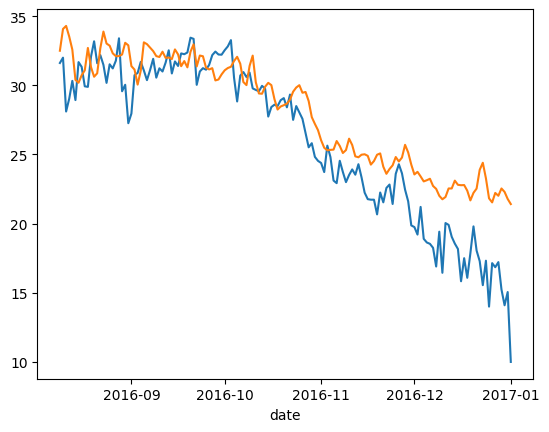

In [95]:
sns.lineplot(x=test_y.index, y=test_y.values)
sns.lineplot(x=test_y.index, y=pred_y.flatten())

# Laboratory Exercise - Bonus Task (+ 2 points)

As a bonus task for this laboratory exercise, calculate the Simple Moving Average (SMA) and Weighted Moving Average (WMA) with 3 timesteps for `mean_temperature` over the past 1, 2, and 3 days:

- **SMA with 3 timesteps ($\text{SMA}_3$)** - the average of temperatures from the previous 3 days:  
  $SMA_3 = \frac{\text{mean\_temperaure}_{lag\_3} +\ \text{mean\_temperaure}_{lag\_2} +\ \text{mean\_temperaure}_{lag\_1}}{1\ +\ 1\ +\ 1}$.

- **WMA with 3 timesteps ($\text{WMA}_3$)** - a weighted average, giving more importance to recent days:  
  $WMA_3 = \frac{1\ \cdot\ \text{mean\_temperaure}_{lag\_3} +\ 2\ \cdot\ \text{mean\_temperaure}_{lag\_2} +\ 3\ \cdot\ \text{mean\_temperaure}_{lag_1}}{1\ +\ 2\ +\ 3}$.

Then use this indicators alongside the other features in the dataset to predict the `mean_temperaure`.

*Hint: Use the `rolling` method from `pandas`. Check the docs at the following link https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html.*

In [151]:
df['SMA_3'] = df['meantemp'].rolling(window=3).mean()


In [152]:
df.columns



Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'WMA_3', 'SMA_3'], dtype='object')

In [150]:
def weighted_moving_average(series, weights):
    return (series * weights).sum() / weights.sum()

weights = pd.Series([1, 2, 3])
df['WMA_3'] = df['meantemp'].rolling(window=3).apply(
    lambda x: weighted_moving_average(x, weights), raw=True
)

In [149]:
df = data.copy()
df



,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


In [153]:
lags = range(3, 0, -1)
features = ['meantemp', 'humidity','wind_speed', 'meanpressure', 'WMA_3', 'SMA_3']


for lag in lags:
    for column in features:
        df[f'{column}_{lag}'] = df[column].shift(lag)



In [154]:
df.dropna(inplace=True)
len(df.columns)
df.columns

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'WMA_3', 'SMA_3',
       'meantemp_3', 'humidity_3', 'wind_speed_3', 'meanpressure_3', 'WMA_3_3',
       'SMA_3_3', 'meantemp_2', 'humidity_2', 'wind_speed_2', 'meanpressure_2',
       'WMA_3_2', 'SMA_3_2', 'meantemp_1', 'humidity_1', 'wind_speed_1',
       'meanpressure_1', 'WMA_3_1', 'SMA_3_1'],
      dtype='object')

In [155]:
from sklearn.model_selection import train_test_split

X, y = df.drop(columns=features), df["meantemp"]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.1, shuffle=False)


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

train_y = scaler.fit_transform(train_y.to_numpy().reshape(-1, 1))

In [156]:
lag = 3

train_X = train_X.reshape(train_X.shape[0], lag, (train_X.shape[1] // lag))
test_X = test_X.reshape(test_X.shape[0], lag, (test_X.shape[1] // lag))
     

In [135]:
print("train_X.shape:", train_X.shape)
print("lags:", lags)
print("train_X.shape[0]:", train_X.shape[0])  # Number of rows
print("train_X.shape[1]:", train_X.shape[1])
print(df.columns)

train_X.shape: (1313, 14)
lags: 3
train_X.shape[0]: 1313
train_X.shape[1]: 14
Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'meantemp_3',
       'humidity_3', 'wind_speed_3', 'meanpressure_3', 'meantemp_2',
       'humidity_2', 'wind_speed_2', 'meanpressure_2', 'meantemp_1',
       'humidity_1', 'wind_speed_1', 'meanpressure_1', 'WMA_3', 'SMA_3'],
      dtype='object')


In [163]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

model = Sequential([
    Input((train_X.shape[1], train_X.shape[2],)),
    LSTM(4, activation="relu", return_sequences=True),
    LSTM(2, activation="relu"),
    Dense(1, activation="linear")
])


In [164]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"],
)

In [165]:
history = model.fit(train_X, train_y, validation_split=0.2, epochs=4, batch_size=16, shuffle=False)


Epoch 1/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3238 - mean_squared_error: 0.3238 - val_loss: 0.2945 - val_mean_squared_error: 0.2945
Epoch 2/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1905 - mean_squared_error: 0.1905 - val_loss: 0.0504 - val_mean_squared_error: 0.0504
Epoch 3/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 4/4
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.0109 - val_mean_squared_error: 0.0109


<Axes: >

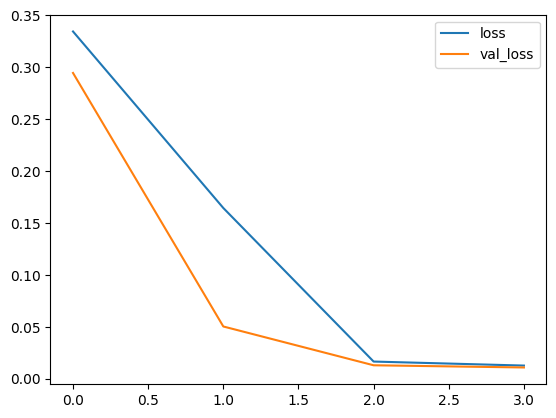

In [166]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [167]:
pred_y = model.predict(test_X)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [168]:
pred_y = scaler.inverse_transform(pred_y)
r2_score(test_y, pred_y)


0.840997304392685

In [169]:
df

,meantemp,humidity,wind_speed,meanpressure,WMA_3,SMA_3,meantemp_3,humidity_3,wind_speed_3,meanpressure_3,...,wind_speed_2,meanpressure_2,WMA_3_2,SMA_3_2,meantemp_1,humidity_1,wind_speed_1,meanpressure_1,WMA_3_1,SMA_3_1
date,,,,,,,,,,,,,,,,,,,,,
2013-01-06,7.000000,82.800000,1.480000,1018.000000,6.944444,7.222222,7.166667,87.000000,4.633333,1018.666667,...,1.233333,1017.166667,7.955556,7.744444,6.000000,86.833333,3.700000,1016.500000,7.083333,7.277778
2013-01-07,7.000000,78.600000,6.300000,1020.000000,6.833333,6.666667,8.666667,71.333333,1.233333,1017.166667,...,3.700000,1016.500000,7.083333,7.277778,7.000000,82.800000,1.480000,1018.000000,6.944444,7.222222
2013-01-08,8.857143,63.714286,7.142857,1018.714286,7.928571,7.619048,6.000000,86.833333,3.700000,1016.500000,...,1.480000,1018.000000,6.944444,7.222222,7.000000,78.600000,6.300000,1020.000000,6.833333,6.666667
2013-01-09,14.000000,51.250000,12.500000,1017.000000,11.119048,9.952381,7.000000,82.800000,1.480000,1018.000000,...,6.300000,1020.000000,6.833333,6.666667,8.857143,63.714286,7.142857,1018.714286,7.928571,7.619048
2013-01-10,11.000000,62.000000,7.400000,1015.666667,11.642857,11.285714,7.000000,78.600000,6.300000,1020.000000,...,7.142857,1018.714286,7.928571,7.619048,14.000000,51.250000,12.500000,1017.000000,11.119048,9.952381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217,17.082505,17.070083,14.000000,94.300000,9.085000,1014.350000,...,8.784211,1016.952381,16.124459,16.153680,16.850000,67.550000,8.335000,1017.200000,16.472619,15.997619
2016-12-29,15.238095,87.857143,6.000000,1016.904762,16.166511,16.435162,17.142857,74.857143,8.784211,1016.952381,...,8.335000,1017.200000,16.472619,15.997619,17.217391,68.043478,3.547826,1015.565217,17.082505,17.070083
2016-12-30,14.095238,89.666667,6.266667,1017.904762,14.996549,15.516908,16.850000,67.550000,8.335000,1017.200000,...,3.547826,1015.565217,17.082505,17.070083,15.238095,87.857143,6.000000,1016.904762,16.166511,16.435162
